# Deep Deterministic Policy Gradients (DDPG)

In [1]:
# Reference: https://github.com/dongminlee94/deep_rl/blob/main/agents/ddpg.py
# This code is heavily derived from the above repo, with modifications to adjust to our problem

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.tensorboard import SummaryWriter

import argparse
from distutils.util import strtobool
import collections
import numpy as np
import gym
from gym.wrappers import TimeLimit, Monitor
from gym.spaces import Discrete, Box, MultiBinary, MultiDiscrete, Space
import time
import random
import os
import matplotlib.pyplot as plt
import time
import argparse
import datetime

/opt/conda/lib/python3.7/site-packages/ale_py/roms/utils.py:90: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for external in metadata.entry_points().get(self.group, []):


In [2]:
# The code for this Buffer implementation comes from the deep_rl repo at:
# https://github.com/dongminlee94/deep_rl/blob/main/agents/common/buffers.py
class ReplayBuffer(object):
    """
    A simple FIFO experience replay buffer for the agent
    """

    def __init__(self, obs_dim, act_dim, size, device):
        self.obs1_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.obs2_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.acts_buf = np.zeros([size, act_dim], dtype=np.float32)
        self.rews_buf = np.zeros(size, dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=np.float32)
        self.ptr, self.size, self.max_size = 0, 0, size
        self.device = device

    def add(self, obs, act, rew, next_obs, done):
        self.obs1_buf[self.ptr] = obs
        self.obs2_buf[self.ptr] = next_obs
        self.acts_buf[self.ptr] = act
        self.rews_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr+1) % self.max_size
        self.size = min(self.size+1, self.max_size)

    def sample(self, batch_size=64):
        idxs = np.random.randint(0, self.size, size=batch_size)
        return dict(obs1=torch.Tensor(self.obs1_buf[idxs]).to(self.device),
                    obs2=torch.Tensor(self.obs2_buf[idxs]).to(self.device),
                    acts=torch.Tensor(self.acts_buf[idxs]).to(self.device),
                    rews=torch.Tensor(self.rews_buf[idxs]).to(self.device),
                    done=torch.Tensor(self.done_buf[idxs]).to(self.device))

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

env = gym.make('Humanoid-v2')
seed = 1234
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
env.seed(seed)

obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.shape[0]
act_limit = env.action_space.high[0]

print (obs_dim, act_dim, act_limit)

/home/gswatiseas/gym/gym/envs/registration.py:579: UserWarning: WARN: The environment Humanoid-v2 is out of date. You should consider upgrading to version v3 with the environment ID `Humanoid-v3`.
  f"The environment {spec.id} is out of date. You should consider "


376 17 0.4


In [4]:
# Hyper params
n_iters = 30
steps_per_iter = 4000
phase = 'train'
max_step = 1000

In [17]:
def identity(x):
    """Return input without any change."""
    return x
"""
Multi Layer Percpetron architecture, to be used for policy function approximation
"""
class MLP(nn.Module):
    def __init__(self, 
                 input_size, 
                 output_size, 
                 output_limit=1.0,
                 hidden_sizes=(64,64), 
                 activation=F.relu, 
                 output_activation=identity,
                 use_output_layer=True,
                 use_actor=False,
    ):
        super(MLP, self).__init__()

        self.input_size = input_size
        self.output_size = output_size
        self.output_limit = output_limit
        self.hidden_sizes = hidden_sizes
        self.activation = activation
        self.output_activation = output_activation
        self.use_output_layer = use_output_layer
        self.use_actor = use_actor

        # Set hidden layers
        self.hidden_layers = nn.ModuleList()
        in_size = self.input_size
        for next_size in self.hidden_sizes:
            fc = nn.Linear(in_size, next_size)
            in_size = next_size
            self.hidden_layers.append(fc)

        # Set output layers
        if self.use_output_layer:
            self.output_layer = nn.Linear(in_size, self.output_size)
        else:
            self.output_layer = identity

    def forward(self, x):
        for hidden_layer in self.hidden_layers:
            x = self.activation(hidden_layer(x))
        x = self.output_activation(self.output_layer(x))
        # If the network is used as actor network, make sure output is in correct range
        x = x * self.output_limit if self.use_actor else x   
        return x
    
"""
DDPG critic definition
"""
class FlattenMLP(MLP):
    def forward(self, x, a):
        q = torch.cat([x,a], dim=-1)
        return super(FlattenMLP, self).forward(q)
    
def hard_target_update(main, target):
    target.load_state_dict(main.state_dict())

def soft_target_update(main, target, tau=0.005):
    for main_param, target_param in zip(main.parameters(), target.parameters()):
        target_param.data.copy_(tau*main_param.data + (1.0-tau)*target_param.data)



In [18]:
class Agent(object):
   """DDPG Agent implementation"""

   def __init__(self,
                env,
                device,
                obs_dim,
                act_dim,
                act_limit,
                steps=0,
                expl_before=2000,
                train_after=1000,
                gamma=0.99,
                act_noise=0.1,
                hidden_sizes=(128,128),
                buffer_size=int(1e4),
                batch_size=64,
                policy_lr=3e-4,
                qf_lr=3e-4,
                gradient_clip_policy=0.5,
                gradient_clip_qf=1.0,
                eval_mode=False,
                policy_losses=list(),
                qf_losses=list(),
                logger=dict(),
   ):

      self.env = env
      self.device = device
      self.obs_dim = obs_dim
      self.act_dim = act_dim
      self.act_limit = act_limit
      self.steps = steps 
      self.expl_before = expl_before
      self.train_after = train_after
      self.gamma = gamma
      self.act_noise = act_noise
      self.hidden_sizes = hidden_sizes
      self.buffer_size = buffer_size
      self.batch_size = batch_size
      self.policy_lr = policy_lr
      self.qf_lr = qf_lr
      self.gradient_clip_policy = gradient_clip_policy
      self.gradient_clip_qf = gradient_clip_qf
      self.eval_mode = eval_mode
      self.policy_losses = policy_losses
      self.qf_losses = qf_losses
      self.logger = logger

      # Main network - policy
      self.policy = MLP(self.obs_dim, self.act_dim, self.act_limit, 
                                    hidden_sizes=self.hidden_sizes, 
                                    output_activation=torch.tanh,
                                    use_actor=True).to(self.device)
      # Main network - critic
      self.qf = FlattenMLP(self.obs_dim+self.act_dim, 1, hidden_sizes=self.hidden_sizes).to(self.device)
      
      # Target network - policy
      self.policy_target = MLP(self.obs_dim, self.act_dim, self.act_limit,
                                           hidden_sizes=self.hidden_sizes, 
                                           output_activation=torch.tanh,
      # Target network - critic                                    use_actor=True).to(self.device)
      self.qf_target = FlattenMLP(self.obs_dim+self.act_dim, 1, hidden_sizes=self.hidden_sizes).to(self.device)
      
      # Initialize target parameters to match main parameters
      hard_target_update(self.policy, self.policy_target)
      hard_target_update(self.qf, self.qf_target)

      # Create optimizers
      self.policy_optimizer = optim.Adam(self.policy.parameters(), lr=self.policy_lr)
      self.qf_optimizer = optim.Adam(self.qf.parameters(), lr=self.qf_lr)
      
      # Experience Replay buffer
      self.replay_buffer = ReplayBuffer(self.obs_dim, self.act_dim, self.buffer_size, self.device)

   def select_action(self, obs):
      action = self.policy(obs).detach().cpu().numpy()
      action += self.act_noise * np.random.randn(self.act_dim)
      return np.clip(action, -self.act_limit, self.act_limit)

   def train_model(self):
      batch = self.replay_buffer.sample(self.batch_size)
      obs1 = batch['obs1']
      obs2 = batch['obs2']
      acts = batch['acts']
      rews = batch['rews']
      done = batch['done']

      if 0: # Check shape of experiences
         print("obs1", obs1.shape)
         print("obs2", obs2.shape)
         print("acts", acts.shape)
         print("rews", rews.shape)
         print("done", done.shape)

      # Prediction Q(s,𝜇(s)), Q(s,a), Q‾(s',𝜇‾(s'))
      q_pi = self.qf(obs1, self.policy(obs1))
      q = self.qf(obs1, acts).squeeze(1)
      q_pi_target = self.qf_target(obs2, self.policy_target(obs2)).squeeze(1)
      
      # Target for Q regression
      q_backup = rews + self.gamma*(1-done)*q_pi_target
      q_backup.to(self.device)

      if 0: # Check shape of prediction and target
         print("q", q.shape)
         print("q_backup", q_backup.shape)

      # DDPG losses
      policy_loss = -q_pi.mean()
      qf_loss = F.mse_loss(q, q_backup.detach())

      # Update policy network parameter
      self.policy_optimizer.zero_grad()
      policy_loss.backward()
      nn.utils.clip_grad_norm_(self.policy.parameters(), self.gradient_clip_policy)
      self.policy_optimizer.step()
      
      # Update Q-function network parameter
      self.qf_optimizer.zero_grad()
      qf_loss.backward()
      nn.utils.clip_grad_norm_(self.qf.parameters(), self.gradient_clip_qf)
      self.qf_optimizer.step()

      # Polyak averaging for target parameter
      soft_target_update(self.policy, self.policy_target)
      soft_target_update(self.qf, self.qf_target)
      
      # Save losses
      self.policy_losses.append(policy_loss.item())
      self.qf_losses.append(qf_loss.item())

   # To save trained models
   def save_models(self, path):
       print (path)
       torch.save(self.policy, path+"model")
       torch.save(self.qf, path+"model")
  
   # For each episode run
   def run(self, max_step):
      step_number = 0
      total_reward = 0.

      obs = self.env.reset()
      done = False

      # Keep interacting until agent reaches a terminal state or agent reaches max_steps
      while not (done or step_number == max_step): 

         # If in eval mode, exploit the learned policy
         if self.eval_mode:
            action = self.policy(torch.Tensor(obs).to(self.device))
            action = action.detach().cpu().numpy()
            next_obs, reward, done, _ = self.env.step(action)
         else:
            self.steps += 1
            # Until expl_before have elapsed, randomly sample actions 
            # from a uniform distribution for exploration. 
            # Afterwards, use the learned policy.
            if self.steps > self.expl_before:
               action = self.select_action(torch.Tensor(obs).to(self.device))
            else:
               action = self.env.action_space.sample()

            # Collect (s, a, s' r, done) tuple for the chosen action
            next_obs, reward, done, _ = self.env.step(action)

            # Add the experience sample to replay buffer
            self.replay_buffer.add(obs, action, reward, next_obs, done)
            
            # Start training when the number of experience is greater than train_after
            if self.steps > self.train_after:
               self.train_model()

         total_reward += reward
         step_number += 1
         obs = next_obs
      
      return step_number, total_reward

SyntaxError: invalid syntax (2756050376.py, line 66)

In [19]:
# Initialise agent
agent = Agent(env, device, obs_dim, act_dim, act_limit, 
                      expl_before=10000, 
                      act_noise=0.1, 
                      hidden_sizes=(256,256), 
                      buffer_size=int(1e6), 
                      batch_size=256,
                      policy_lr=3e-4, 
                      qf_lr=3e-4)

In [20]:
### This is the actual train/eval loop.
# We run 10 episodes of evaluation for every 4000 steps (steps_per_iter) taken by the agent in the environment during training

start_time = time.time()

total_num_steps = 0
train_sum_returns = 0.
train_num_episodes = 0
eval_mode = 0

train_avg_ret = []
train_ep_ret = []
eval_avg_ret = []
eval_ep_ret = []

for i in range(n_iters):
        # Perform the training phase, during which the agent learns
        if phase == 'train':
            train_step_count = 0

            while train_step_count <= steps_per_iter:
                eval_mode = False
                
                # Run one episode
                train_step_length, train_episode_return = agent.run(max_step)
                
                total_num_steps += train_step_length
                train_step_count += train_step_length
                train_sum_returns += train_episode_return
                train_num_episodes += 1

                train_average_return = train_sum_returns / train_num_episodes if train_num_episodes > 0 else 0.0
                
                train_avg_ret.append(train_average_return)
                train_ep_ret.append(train_episode_return)


        # Perform the evaluation phase -- no learning
        eval_sum_returns = 0.
        eval_num_episodes = 0
        eval_mode = True

        for _ in range(10):
            # Run one episode
            eval_step_length, eval_episode_return = agent.run(max_step)

            eval_sum_returns += eval_episode_return
            eval_num_episodes += 1

        eval_average_return = eval_sum_returns / eval_num_episodes if eval_num_episodes > 0 else 0.0
        eval_avg_ret.append(eval_average_return)
        eval_ep_ret.append(eval_episode_return)


        if phase == 'train':
            print('---------------------------------------')
            print('Iterations:', i + 1)
            print('Steps:', total_num_steps)
            print('Episodes:', train_num_episodes)
            print('EpisodeReturn:', round(train_episode_return, 2))
            print('AverageReturn:', round(train_average_return, 2))
            print('EvalEpisodes:', eval_num_episodes)
            print('EvalEpisodeReturn:', round(eval_episode_return, 2))
            print('EvalAverageReturn:', round(eval_average_return, 2))
            print('OtherLogs:', agent.logger)
            print('Time:', int(time.time() - start_time))
            print('---------------------------------------')
        else:
            print('---------------------------------------')
            print('EvalEpisodes:', eval_num_episodes)
            print('EvalEpisodeReturn:', round(eval_episode_return, 2))
            print('EvalAverageReturn:', round(eval_average_return, 2))
            print('Time:', int(time.time() - start_time))
            print('---------------------------------------')
            

---------------------------------------
Iterations: 1
Steps: 4004
Episodes: 161
EpisodeReturn: 96.54
AverageReturn: 124.42
EvalEpisodes: 10
EvalEpisodeReturn: 117.88
EvalAverageReturn: 126.23
OtherLogs: {'LossPi': -280.05249, 'LossQ': 231.24587}
Time: 19
---------------------------------------
---------------------------------------
Iterations: 2
Steps: 8018
Episodes: 327
EpisodeReturn: 273.7
AverageReturn: 123.01
EvalEpisodes: 10
EvalEpisodeReturn: 204.0
EvalAverageReturn: 135.55
OtherLogs: {'LossPi': -277.74837, 'LossQ': 225.34678}
Time: 45
---------------------------------------
---------------------------------------
Iterations: 3
Steps: 12031
Episodes: 442
EpisodeReturn: 207.66
AverageReturn: 137.37
EvalEpisodes: 10
EvalEpisodeReturn: 211.21
EvalAverageReturn: 215.53
OtherLogs: {'LossPi': -280.8185, 'LossQ': 222.75324}
Time: 72
---------------------------------------
---------------------------------------
Iterations: 4
Steps: 16035
Episodes: 621
EpisodeReturn: 76.38
AverageReturn

---------------------------------------
Iterations: 29
Steps: 116983
Episodes: 2462
EpisodeReturn: 366.89
AverageReturn: 235.16
EvalEpisodes: 10
EvalEpisodeReturn: 301.11
EvalAverageReturn: 437.34
OtherLogs: {'LossPi': -305.87287, 'LossQ': 242.14591}
Time: 830
---------------------------------------
---------------------------------------
Iterations: 30
Steps: 120999
Episodes: 2505
EpisodeReturn: 471.07
AverageReturn: 238.72
EvalEpisodes: 10
EvalEpisodeReturn: 375.37
EvalAverageReturn: 418.16
OtherLogs: {'LossPi': -307.67462, 'LossQ': 242.94128}
Time: 860
---------------------------------------


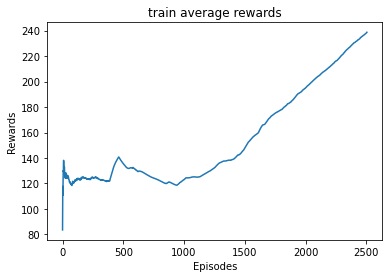

Text(0.5, 1.0, 'train episode rewards')

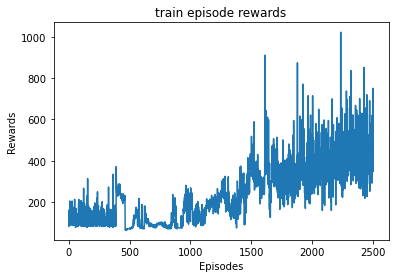

In [21]:
plt.show()
plt.plot(train_avg_ret)
plt.xlabel("Episodes")
plt.ylabel("Rewards")
plt.title("train average rewards")

plt.show()
plt.plot(train_ep_ret)
plt.xlabel("Episodes")
plt.ylabel("Rewards")
plt.title("train episode rewards")

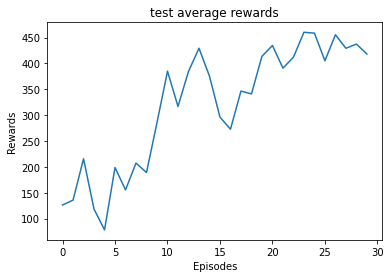

Text(0.5, 1.0, 'test episode rewards')

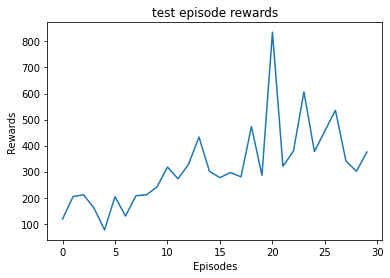

In [22]:
plt.show()
plt.plot(eval_avg_ret)
plt.xlabel("Episodes")
plt.ylabel("Rewards")
plt.title("test average rewards")

plt.show()
plt.plot(eval_ep_ret)
plt.xlabel("Episodes")
plt.ylabel("Rewards")
plt.title("test episode rewards")

In [14]:
flag = ""

In [20]:
from datetime import datetime

now = datetime.now() # current date and time
date_time = str(now.strftime("%m:%d:%Y_%H:%M:%S"))
print (date_time)


algo = "DDPG"
path = "Results/" + algo + date_time + flag
np.save(path +"_train_avg", train_avg_ret)
np.save(path + "_test_avg", eval_avg_ret)
np.save(path +"_train_ep", train_ep_ret)
np.save(path + "_test_ep", eval_ep_ret)

12:11:2021_16:58:07


In [21]:
agent.save_models(path)